# Simulation of Options Prices

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import default_rng
from scipy.stats import norm
import time

In [2]:
m = int(1e4) # Number of replications (needs about 10^5 for stability)
n = 100 # Number of RVs Y generated for each process
mu = 0.05 # default return, equivalent to risk free rate
r = mu # Risk free rate
k = 130 # Default strike
sigma2 = 0.15 # Default volatility
S0 = 100 # Default starting price of stock
T = 1 # Default time until expiry, ie 1 period

## 1. Brownian Motion

Generate a sequence of n $Y_i$'s with mean 0, variance 1

We can generate a simulated Brownian Motion as follows:

$W(\frac{i}{n})=W(\frac{i-1}{n}) + \frac{Y_i}{\sqrt{n}}$

In [3]:
def bm(m=int(1e4),n=100, crn=None, vectorize=True):
    """ 
    Variance reduction using Common Random Numbers passed to the bm function.
    Used when calculating for instance option values as underlying or other input varies
    Not needed for simple demo of bm or gbm
    """
    
    if crn is not None:
        m = crn.shape[0]
        n = crn.shape[1]
        Y = crn
    else:
        Y = np.random.normal(size=(m,n))
        
    W = np.zeros((m,n)) 

    if not vectorize:
        # (Keep W(0) <- 0)
        for i in range(m):
            for j in range(1,n):
                W[i,j] = W[i,j-1] + Y[i,j]/(n**0.5)
        return W
  
    # Vectorized:
    Y_cumsum = np.cumsum(Y, axis=1)
    W[:,1:] = W[:,:-1] + Y_cumsum[:,1:]/(n**0.5)
    
    
    return W
    

def plot(data, title, xlabel, ylabel):
    plt.clf()
    plt.plot(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

Elapsed: 0.035977840423583984


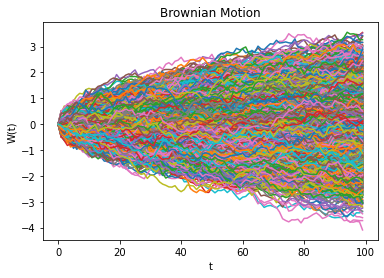

In [4]:
start = time.time()
W = bm(m=int(1e4),n=100)
end = time.time()
print(f"Elapsed: {end-start}")

plot(W.T, "Brownian Motion", "t", "W(t)")

## Geometric Brownian Motion

Geometric Brownian motion can be defined as the following continuous stochastic process:

$ S(t) = S(0)\exp\{(\mu-\frac{\sigma^2}{2})t + \sigma W(t)\} $

In [5]:
### Set simulation constants and initialize m*n array

def gbm(start_price=100, mu=0.05, sigma2 = 0.15, n=100, m=int(1e4), crn=None, vectorize=True):
    if crn is not None:
        m = crn.shape[0]
        n = crn.shape[1]
    
    W = bm(m=m,n=n,crn=crn)
    S = np.zeros((m,n))
    S[:,0] = start_price    
    
    if not vectorize:
        for i in range(m):
            for j in range(1,n):
                S[i,j] = start_price*(np.exp((mu-sigma2/2)*j/n +
                             sigma2**0.5*W[i,j] ))
        return S

    # J is an m*n matrix whose values are the column indices (and each row is the same)
    J = np.arange(n)[1:]
    S[:,1:] = start_price*(np.exp((mu-sigma2/2)*J/n + sigma2**0.5*W[:,1:]))

    return S
        

Elapsed: 0.046952009201049805


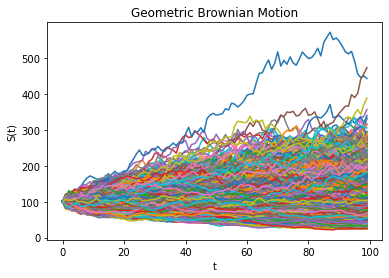

In [6]:
start = time.time()
S_ = gbm(start_price=100, mu=0.05, sigma2=0.15, m=int(1e4), n=100)
end = time.time()
print(f"Elapsed: {end-start}")

plot(S_.T, "Geometric Brownian Motion", "t", "S(t)")

Can try varying mu and sigma2 and compare

# European Call - Monte Carlo Simulation

We can calculate the values of a call as follows:

$Price = e^{-rT} E[(S(T)-k)^+]$ 

First lets calculate the $E[S(T)]$ by averaging over the last column of all the brownian motion runs above

In [7]:
def mc_eurocall(underlying=100, k=130, mu=0.05, r=0.05, sigma2=0.15, m=int(1e4), n=100, T=1, crn = None, verbose=True):
    """
    Montecarlo Simulation of European Call (for stocks)
    T : Time to expiration as a fraction of a year
    """
    
    if crn is not None:
        m = crn.shape[0]
        n = crn.shape[1]
    if T==0:
        if underlying > k: return underlying-k
        else: return 0
            

    S = gbm(start_price=underlying, mu=r, sigma2= sigma2, m=m, n=n, crn=crn)
    payoff_col = round(T*n) - 1
    
    #Calculate the payout vector for all of the runs above
    payout = S[:,payoff_col]-k
    #print(payoff_col)
    
    payout = np.array((payout,np.zeros(m)))
    payout = payout.max(axis=0)
    
    #The expected payout is the mean of all the payouts
    exp_payout = np.mean(payout)    
    European_Call_MC = np.exp(-r*T)*exp_payout

    if verbose:
        print(f"The expected payout is {round(exp_payout,4)}")
        print(f"The simulated option value is {round(European_Call_MC,4)}")
    
    return European_Call_MC
    
    

In [8]:
mc_eurocall(underlying=100, k=130, mu=0.05, sigma2=0.15, m=int(1e5), n=100, verbose=True, T = 1)

The expected payout is 8.2636
The simulated option value is 7.8605


7.860549101044844

Calculate the payout vector for all of the runs above

The expected payout is the mean of all the payouts

Value of the **130 Strike European Call** with 1 year to expiration with underlying stock price of **$100**, 100 days out from expiration 

(with a risk free rate of 0.05 and volatility =$ \sqrt 0.15$)

Comprison with Black-Scholes calculation:

In [9]:
def bs_call(underlying=100, k=130, mu=0.05, r=0.05, sigma2=0.15, T=1, verbose=True):
    """
    Black Scholes Call valuation (for Stocks)
    """
    S = underlying
    d1 = (np.log(S/k) + (r + sigma2/2)*T)/(sigma2**0.5*T**0.5)    
    d2 = d1 - sigma2**0.5* T**0.5
    #put_val = k * np.exp(-r*T) * norm.cdf(-1*d2) - S*norm.cdf(-1*d1)
    call_val = S*norm.cdf(d1) - k*np.exp(-1*r*T)* norm.cdf(d2)
    return call_val

In [10]:
print(f"The Black-Scholes option value is {round(bs_call(),4)}")

The Black-Scholes option value is 7.8172


## European Put - Monte Carlo Simulation

We can calculate the values of a put as follows:

$Price = e^{-rT} E[k-S(T))]^+$ 

First lets calculate the $E[S(T)]$ by averaging over the last column of all the brownian motion runs above

In [11]:
def mc_europut(underlying=100, k=130, mu=0.05, r = 0.05, sigma2=0.15, m=int(1e4), n=100, T=1, crn = None, verbose=True):
    """
    Montecarlo Simulation of European put (for stocks)
    T : Time to expiration as a fraction of a year
    """
    if crn is not None:
        m = crn.shape[0]
        n = crn.shape[1]
    if T==0:
        if k > underlying : return k - underlying
        else: return 0
            

    S = gbm(start_price=underlying, mu=r, sigma2= sigma2, m=m, n=n, crn=crn)
    payoff_col = round(T*n) - 1
    
    #Calculate the payout vector for all of the runs above
    payout = k - S[:,payoff_col]  # -1* payout of the call
    
    payout = np.array((payout,np.zeros(m)))
    payout = payout.max(axis=0)
    
    #The expected payout is the mean of all the payouts
    exp_payout = np.mean(payout)    
    European_Put_MC = np.exp(-r*T)*exp_payout

    if verbose:
        print(f"The expected payout is {round(exp_payout,4)}")
        print(f"The simulated option value is {round(European_Put_MC,4)}")
    
    return European_Put_MC

In [12]:
mc_europut(underlying=100, k=130, mu=0.05, sigma2=0.15, m=int(1e5), n=100, verbose=True, T = 1)

The expected payout is 33.0981
The simulated option value is 31.4839


31.48389180209946

Lets compare this with Black-Scholes for the put

In [13]:
def bs_put(underlying=100, k=130, mu=0.05, r=0.05, sigma2=0.15, T=1, verbose=True):
    """
    Black Scholes Put valuation (for Stocks)
    """
    S = underlying
    d1 = (np.log(S/k) + (r + sigma2/2)*T)/(sigma2**0.5*T**0.5)    
    d2 = d1 - sigma2**0.5* T**0.5
    put_val = k * np.exp(-r*T) * norm.cdf(-1*d2) - S*norm.cdf(-1*d1)
    return put_val
    
    
    

In [14]:
bs_put(underlying=100, k=130, mu=0.05, sigma2=0.15, T = 1)

31.476980430235088

## Asian Call - Monte Carlo Simulation
An Asian option is an option type where the payoff depends on the average price of the underlying asset over a certain period of time.
Source: [Investopedia.com](https://www.investopedia.com/terms/a/asianoption.asp)

In [15]:
def mc_asiancall(underlying=100, k=130, mu=0.05, sigma2=0.15, m=int(1e4), n=100, T=1, verbose=True):

    S = gbm(start_price=underlying, mu=mu, sigma2= sigma2, m=m, n=n)
    avg_underlying = np.mean(S, axis=1)
    
    plt.clf()
    counts, bins = np.histogram(avg_underlying)
    plt.title("Histogram - Mean underlying asset price")
    plt.ylabel("Simulation count")
    plt.xlabel("Underlying price")
    plt.hist(bins[:-1], bins, weights=counts, label="Simulated mean underlying")
    plt.axvline(x=k, color='r', label="Strike price")
    plt.legend()
    
    payout = avg_underlying - k
    
    payout = np.array((payout, np.zeros(m)))
    payout = payout.max(axis=0)
    
    # The expected payout is the mean of all the payouts
    exp_payout = np.mean(payout)    
    asian_call_mc = np.exp(-r*T)*exp_payout

    if verbose:
        print(f"The expected payout is {round(exp_payout,4)}")
        print(f"The simulated option price is {round(asian_call_mc,4)}")
    
    return (asian_call_mc, exp_payout)

The expected payout is 2.1461
The simulated option price is 2.0414


(2.0414259121195086, 2.1460920568043007)

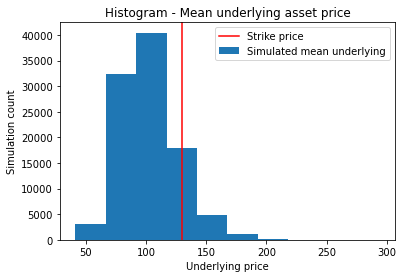

In [16]:
mc_asiancall(underlying=100, k=130, mu=0.05, sigma2=0.15, m=int(1e5), n=100, verbose=True, T = 1)

# Simulation of the Greeks

## Delta

The option delta is the change in the option value per change in the underlying. More formally, it is the partial derivative of an options value with respect to the underlying.

$$ \Delta \equiv \frac{\partial V}{\partial S}$$

### Delta simulated at a point

Lets try to accurately simulate the delta at a specific point when the underlying stock is 100, continuing with our example above. We will compute the expected change in the option value for a $1 change in the underlying stock which should theoretically equal our delta 

In [17]:
def mc_delta(contract = "call", underlying=100, k=130, mu=0.05, r=0.05, sigma2=0.15, m=int(1e5),n=100, verbose=False,T =1,crn=None):
    """
    Delta - computed by simulating option value at 2 adjacent underylings, and approximating dV/dS
    Use contract to specify "call" (Default) or "put"
    """
    if contract == "call":
        p1 = mc_eurocall(underlying=underlying, k=k, mu=mu, r=r, sigma2=sigma2, m=m, n=n, T=T, crn=crn,verbose=False)
    elif contract == "put":
        p1= mc_eurocall(underlying=underlying, k=k, mu=mu, r = r, sigma2=sigma2, m=m, n=n, T=T, crn=crn,verbose=False)
    
    #option price at point + small change in price (ie $1)
    if contract == "call":
        p2 = mc_eurocall(underlying=underlying+1, k=k, mu=mu, r=r, sigma2=sigma2, m=m, n=n, T=T, crn=crn, verbose=False)
    elif contract == "put":
        p2 = mc_europut(underlying=underlying+1, k=k, mu=mu, r=r, sigma2=sigma2, m=m, n=n, T=T, crn=crn, verbose=False)  
        
    delta = (p2-p1)/1
    return round(delta,4)
    

In [18]:
m = int(1e5)
n = 100
crn=np.random.normal(size=(m,n))
mc_eurocall(underlying=101,crn=crn) - mc_eurocall(underlying=100,crn=crn)

The expected payout is 8.5181
The simulated option value is 8.1027
The expected payout is 8.1369
The simulated option value is 7.74


0.362678663409822

In [19]:
m = int(1e5)
n = 100
delta_mc_ = mc_delta(crn=None, m=m, n=n)
delta_mc_VR = mc_delta(crn=np.random.normal(size=(m,n)))

In [20]:
#p2 = 8.072317188486938
#p1 = 7.740754997855431
#delta_MC = (p2-p1)/1
#delta_MC
print(f"The Monte Carlo simulated delta is {round(delta_mc_,4)} without variance reduction")
print(f"The Monte Carlo simulated delta is {round(delta_mc_VR,4)} with variance reduction")

The Monte Carlo simulated delta is 0.2562 without variance reduction
The Monte Carlo simulated delta is 0.3675 with variance reduction


In [21]:
# Black-Scholes calculation of the delta at this point
K = 130
S0 = 100
r = 0.05
T = 1
sigma2 = 0.15

d1 = (np.log(S0/K) + (r + sigma2/2)*1)/(sigma2**0.5*T**0.5)
d1
delta_BS = norm.cdf(d1)
delta_BS

print(f"The Black-Scholes calculation of delta is {round(delta_BS,4)}")

The Black-Scholes calculation of delta is 0.3614


In [22]:
CRNs = np.random.normal(size=(int(1e5),100))
mc_delta(underlying=100,k=130,crn=CRNs)


0.3639

### Delta simulated as underlying varies

Note that this was very computationally intensive. We will now sacrifice some accuracy in our calculations to compute delta over a whole range of underlying prices

In [23]:
x_ = 100 
fair_price = np.zeros(x_) # Array of option prices to be computed as underlying varies
print(f"Strike price {130}")
offset = 30
CRNs = None
for i in range(0,2*x_,2):
    fair_price[i//2] = mc_eurocall(underlying=offset+i, k=130, mu=0.05, sigma2=0.15, m=7*int(1e4), n=100, crn=None, verbose=False)
    #print(f"underlying {offset + i}, fair_price {fair_price[i]}")
    
    

Strike price 130


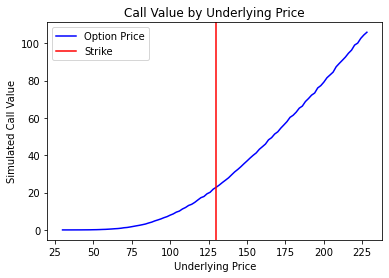

In [24]:
plt.plot([*range(30,230,2)],fair_price,color="blue",label="Option Price")
plt.title("Call Value by Underlying Price")
plt.ylabel("Simulated Call Value")
plt.xlabel("Underlying Price")
plt.axvline(K,color="red",label="Strike")
plt.legend()
plt.show()

Note that the **delta** of the call will be the **slope of the blue curve**. Theoretically the delta should converge to 0 when the option is far out of the money and 1 when the option is far in the money

Text(0, 0.5, 'Simulated Delta')

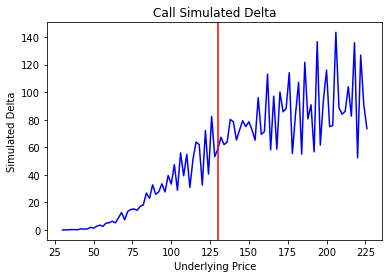

In [25]:
plt.title("Call Simulated Delta")
plt.plot([*range(30,230,2)[:-1]],(fair_price[1:] - fair_price[:-1])/2*100,color="blue")
plt.axvline(K,color="red",label="Strike")
plt.xlabel("Underlying Price")
plt.ylabel("Simulated Delta")

Now lets run the exact same simulation with variance reduction using **CRNs for variance reduction**

Strike price 130


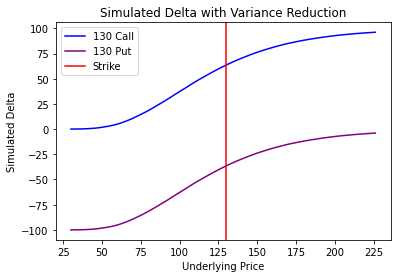

In [26]:
x_ = 100  # number of options to simulate along the curve
fair_price_call = np.zeros(x_) # Array of call option prices to be computed as underlying varies
fair_price_put = np.zeros(x_)
print(f"Strike price {130}")
offset = 30
CRNs = np.random.normal(size=(int(1e5),100))
for i in range(0,100):
    s = i*2 + 30
    fair_price_call[i] = mc_eurocall(underlying=s, k=130, mu=0.05, sigma2=0.15, m=7*int(1e4), n=100, crn=CRNs, verbose=False)
    fair_price_put[i] = mc_europut(underlying=s, k=130, mu=0.05, sigma2=0.15, m=7*int(1e4), n=100, crn=CRNs, verbose=False)
    
plt.title("Simulated Delta with Variance Reduction")
deltas_call = (fair_price_call[1:] - fair_price_call[:-1])/2*100 # By convention we multiply the delta by 100 to give a whole number
deltas_put = (fair_price_put[1:] - fair_price_put[:-1])/2*100 # By convention we multiply the delta by 100 to give a whole number

plt.plot([*range(30,230,2)[:-1]],deltas_call,color="blue",label="130 Call")
plt.plot([*range(30,230,2)[:-1]],deltas_put,color="purple",label="130 Put")
plt.axvline(K,color="red",label="Strike")
plt.legend()
plt.xlabel("Underlying Price")
plt.ylabel("Simulated Delta")
plt.show()
    

We get a much smoother curve with CRNs and variance reduction!

## Gamma


The gamma is the change in delta with respect to the underlying.

$$\Gamma \equiv \frac{\partial \Delta}{\partial S} = \frac{\partial^2 V}{\partial S^2}$$

Now lets simulate gamma (the change in delta) with respect to change in the underlying.
We will do this at a single point (underlying = 100)


(Note the cell below may take a few minutes to run)

In [27]:
def mc_gamma(contract = "call", underlying=100, k=130, mu=0.05, r=0.05, sigma2=0.15, m=int(1e5),n=100, verbose=False,T =1,crn=None):
    """
    Delta - computed by simulating option value at 2 adjacent underylings, and approximating dV/dS
    Use contract to specify "call" (Default) or "put"
    """
    if contract == "call":
        p1 = mc_delta(contract="call",underlying=underlying, k=k, mu=mu, r=r, sigma2=sigma2, m=m, n=n, T=T, crn=crn,verbose=False)
    elif contract == "put":
        p1= mc_delta(contract="put",underlying=underlying, k=k, mu=mu, r = r, sigma2=sigma2, m=m, n=n, T=T, crn=crn,verbose=False)
    
    #option price at point + small change in price (ie $1)
    if contract == "call":
        p2 = mc_delta(contract="call",underlying=underlying+1, k=k, mu=mu, r=r, sigma2=sigma2, m=m, n=n, T=T, crn=crn, verbose=False)
    elif contract == "put":
        p2 = mc_delta(contract="put",underlying=underlying+1, k=k, mu=mu, r=r, sigma2=sigma2, m=m, n=n, T=T, crn=crn, verbose=False)  
        
    gamma = (p2-p1)/1
    return round(gamma,4)
    

In [28]:
CRNs = np.random.normal(size=(int(1e5),100))
mc_gamma(contract="call",crn=CRNs)

0.0093

In [29]:
gamma_bs = norm.pdf(d1)/(S0*sigma2**0.5*T**0.5)
gamma_bs
print(f"The Black-Scholes calculated gamma is {round(gamma_bs,6)}")

The Black-Scholes calculated gamma is 0.009673


In [30]:
CRNs = np.random.normal(size=(int(1e5),100))
mc_gamma(contract="put",crn=CRNs)

-0.9907

### Simulating Gamma as underlying varies

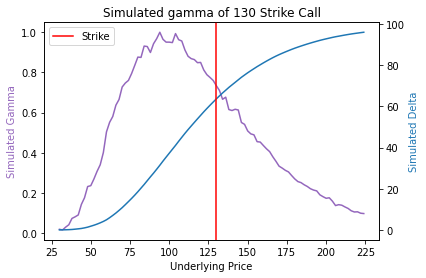

In [31]:
gammas = (deltas_call[1:]-deltas_call[:-1])/2
deltas_ = deltas_call[:-1] # make sure gammas and deltas are same length

underlying = [*range(30,230,2)[:-2]]

fig, ax1 = plt.subplots()
color = "tab:purple"
ax1.set_xlabel("Underlying Price")
ax1.set_ylabel("Simulated Gamma",color=color)
ax1.plot(underlying,gammas,color=color,label="Gamma")
#plt.legend()

ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel("Delta", color=color)
ax2.plot(underlying,deltas_,color=color)

plt.xlabel("Underlying Price")
plt.ylabel("Simulated Delta")

plt.axvline(K,color="red",label="Strike")
plt.title(f"Simulated gamma of {k} Strike Call")
plt.legend()
plt.show()
#plt.plot(gammas, color="purple")

## Theta

The theta $\Theta$ is the time decay, or the rate at which the option loses value as time passes. The options value comprises of 2 components, the intrinsic value and the time value. All else being equal, a $\Theta$ of -0.1 would signify that the option would lose value by $0.10 for each day that passes.

Let $V\equiv$ Option Value, $\tau \equiv$ time to expiration


$$\Theta \equiv -\frac{\partial V}{\partial \tau}$$



Lets now simulate this with respect to our call option



In [32]:
def mc_theta(contract = "call", underlying=100, k=130, mu=0.05, r=0.05, sigma2=0.15, m=int(1e5),n=100, verbose=False,T =1,crn=None):
    """
    Delta - computed by simulating option value at 2 adjacent underylings, and approximating dV/dS
    Use contract to specify "call" (Default) or "put"
    """
    if contract == "call":
        p1 = mc_eurocall(underlying=underlying, k=k, mu=mu, r=r, sigma2=sigma2, m=m, n=n, T=T, crn=crn,verbose=False)
    elif contract == "put":
        p1= mc_europut(underlying=underlying, k=k, mu=mu, r = r, sigma2=sigma2, m=m, n=n, T=T, crn=crn,verbose=False)
    
    #option price at point + small change in price (ie $1)
    if contract == "call":
        p2 = mc_eurocall(underlying=underlying, k=k, mu=mu, r=r, sigma2=sigma2, m=m, n=n, T=T-0.01, crn=crn, verbose=False)
    elif contract == "put":
        p2 = mc_europut(underlying=underlying, k=k, mu=mu, r=r, sigma2=sigma2, m=m, n=n, T=T-0.01, crn=crn, verbose=False)  
        
    theta = (p2-p1)/1
    return round(theta,4)
    

In [33]:
CRNs = np.random.normal(size=(3*int(1e5),100))
tmc = mc_theta(k=130,underlying=130,T=1,crn=CRNs,contract="call")
print(f"theta calculated via MonteCarlo Simulation {round(tmc,4)}")

theta calculated via MonteCarlo Simulation -0.128


In [34]:
# Via BS_method:


d1 = (np.log(S0/k) + (r + sigma2/2)*1)/(sigma2**0.5*(T)**0.5)
d2 = d1 -sigma2**0.5*T**0.5
theta_bs = -S0*norm.pdf(d1)*sigma2**0.5/(2*(T)**0.5) - r*k*np.exp(-r*T)*norm.cdf(d2)
theta_bs /= 100

print(f"theta via Black Scholes: {round(theta_bs,4)}")

theta via Black Scholes: -0.0867


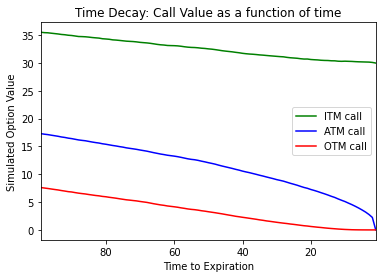

In [35]:
k_atm = 100 
k_itm = 70
k_otm = 130
S = 100
CRNs = np.random.normal(size=(3*(int(1e4)), 100))

option_values_itm = np.zeros(100)
option_values_atm = np.zeros(100)
option_values_otm = np.zeros(100)

time = range(0,100)

for i in range(0,100):
    i_ = i*0.01
    option_values_itm[i] = mc_eurocall(underlying=S,k=k_itm,T=i_,crn=CRNs,verbose=False)
    option_values_atm[i] = mc_eurocall(underlying=S,k=k_atm,T=i_,crn=CRNs,verbose=False)
    option_values_otm[i] = mc_eurocall(underlying=S,k=k_otm,T=i_,crn=CRNs,verbose=False)

    
option_values_atm = option_values_atm[::-1][:-1]
option_values_itm = option_values_itm[::-1][:-1]
option_values_otm = option_values_otm[::-1][:-1]
time = np.array(time)[::-1][:-1]
plt.title("Time Decay: Call Value as a function of time")
plt.plot(time, option_values_itm, color="green", label="ITM call")
plt.plot(time, option_values_atm, color="blue", label="ATM call")
plt.plot(time, option_values_otm, color="red", label="OTM call")
plt.xlim(max(time),min(time))
plt.xlabel("Time to Expiration")
plt.ylabel("Simulated Option Value")
plt.legend()
plt.show()
    
    



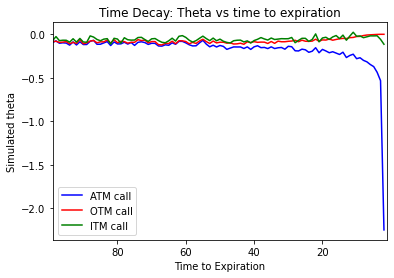

In [36]:
theta_atm = option_values_atm[1:]-option_values_atm[:-1]
theta_itm = option_values_itm[1:]-option_values_itm[:-1]
theta_otm = option_values_otm[1:]-option_values_otm[:-1]

plt.title("Time Decay: Theta vs time to expiration")
plt.plot(time[:-1], theta_atm,color="blue",label = "ATM call")
plt.plot(time[:-1], theta_otm,color="red",label = "OTM call")
plt.plot(time[:-1], theta_itm,color="green",label = "ITM call")
plt.xlim(max(time),min(time))
plt.xlabel("Time to Expiration")
plt.ylabel("Simulated theta")
plt.legend()

## Vega

The vega of the option measures the change in value of the option with respect to a change in volatility.

$$\kappa \equiv \frac{\partial V}{\partial \sigma}$$

Note: Vega is not a greek letter, we will use $\kappa$ instead.

In [37]:
def mc_vega(contract = "call", underlying=100, k=130, mu=0.05, r=0.05, sigma2=0.15, m=int(1e5),n=100, verbose=False,T =1,crn=None):
    """
    Delta - computed by simulating option value at 2 adjacent underylings, and approximating dV/dS
    Use contract to specify "call" (Default) or "put"
    """
    if contract == "call":
        p1 = mc_eurocall(underlying=underlying, k=k, mu=mu, r=r, sigma2=sigma2, m=m, n=n, T=T, crn=crn,verbose=False)
    elif contract == "put":
        p1= mc_europut(underlying=underlying, k=k, mu=mu, r = r, sigma2=sigma2, m=m, n=n, T=T, crn=crn,verbose=False)
    
    # Now lets increment the volatility 
    if contract == "call":
        p2 = mc_eurocall(underlying=underlying, k=k, mu=mu, r=r, sigma2=(sigma2**0.5+0.01)**2, m=m, n=n, T=T, crn=crn, verbose=False)
    elif contract == "put":
        p2 = mc_europut(underlying=underlying, k=k, mu=mu, r=r, sigma2=(sigma2**0.5+0.01)**2, m=m, n=n, T=T, crn=crn, verbose=False)  
        
    vega = (p2-p1)
    print(p2)
    print(p1)
    return round(vega,4)
    
    

Lets look at an at the money call as time passes:
K = 130, S = 130

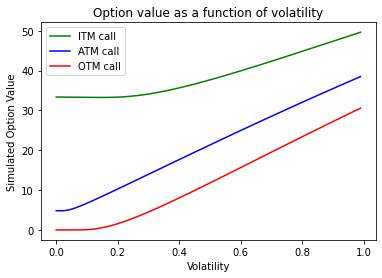

In [38]:
k_atm = 100 
k_itm = 70
k_otm = 130
S = 100
CRNs = np.random.normal(size=(3*(int(1e4)), 100))

option_values_itm = np.zeros(100)
option_values_atm = np.zeros(100)
option_values_otm = np.zeros(100)

vols = range(0,100)

for i in range(0,100):
    i_ = i*0.01
    option_values_itm[i] = mc_eurocall(underlying=S,sigma2= i_**2,k=k_itm,crn=CRNs,verbose=False)
    option_values_atm[i] = mc_eurocall(underlying=S,sigma2= i_**2, k=k_atm,crn=CRNs,verbose=False)
    option_values_otm[i] = mc_eurocall(underlying=S,sigma2= i_**2, k=k_otm,crn=CRNs,verbose=False)

    
option_values_atm = option_values_atm[::]
option_values_itm = option_values_itm[::]
option_values_otm = option_values_otm[::]
vols = np.arange(100)/100
plt.title("Option value as a function of volatility")
plt.plot(vols, option_values_itm, color="green", label="ITM call")
plt.plot(vols, option_values_atm, color="blue", label="ATM call")
plt.plot(vols, option_values_otm, color="red", label="OTM call")
plt.xlabel("Volatility")
plt.ylabel("Simulated Option Value")
plt.legend()
plt.show()

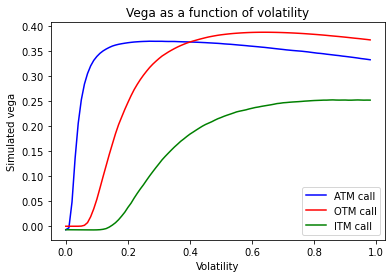

In [39]:
vega_atm = option_values_atm[1:]-option_values_atm[:-1]
vega_itm = option_values_itm[1:]-option_values_itm[:-1]
vega_otm = option_values_otm[1:]-option_values_otm[:-1]

plt.title("Vega as a function of volatility")
plt.plot(vols[:-1], vega_atm,color="blue",label = "ATM call")
plt.plot(vols[:-1], vega_otm,color="red",label = "OTM call")
plt.plot(vols[:-1], vega_itm,color="green",label = "ITM call")
#plt.xlim(max(time),min(time))
plt.xlabel("Volatility")
plt.ylabel("Simulated vega")
plt.legend()